# 정확도

정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표이다.  
하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다.

예제) 정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지?

단지 성별 조건 하나만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생한다.

In [1]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    from sklearn.preprocessing import LabelEncoder
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 위에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [2]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit( ) 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict( ) 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('C:\\Users\\jjku0\\OneDrive\\data\\titanic\\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


특히 정확도는 불균형한(imalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0 값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits() 를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True 이고 이를 astype(int)로 1로 변환, 7번이 아니면 False 이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

불균형한 데이터로 생성한 y_test 의 데이터 분포도를 확인하고 MyFakeClassifier 를 이용해 예측과 평가를 수행

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0 으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0 으로 하여도 정확도는:0.900


단지 모든 것을 0 으로만 예측해도 MyFakeClassifier의 정확도가 90% 이다.  
이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안된다.  
이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다.

# 오차 행렬

오차행렬(confusion matrix, 혼동행렬)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표이다.  
즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다.

<div>
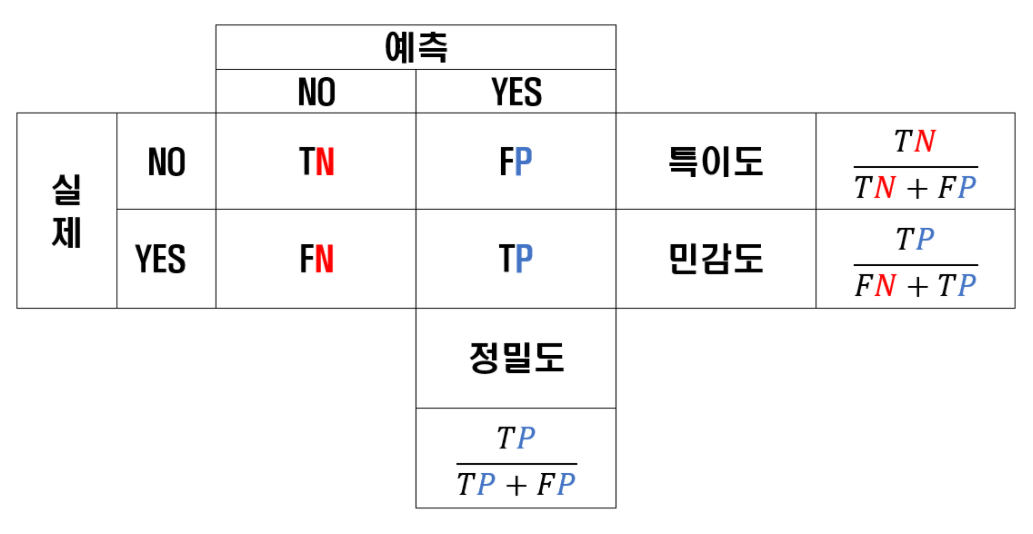
</div>

TN : 예측값을 Negative 값 0으로 예측했고 실제 값 역시 Negative 값 0  
FP : 예측값을 Positive 값 1으로 예측했는데 실제 값은 Negative 값 0  
FN : 예측값을 Negative 값 0으로 예측했는데 실제 값은 Positive 값 1  
TP : 예측값을 Positive 값 1으로 예측했고 실제 값 역시 Positive 값 1

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)  # ndarray 형태

array([[405,   0],
       [ 45,   0]], dtype=int64)

TN : array[0,0] = 405  
FP : array[0,1] = 0  
FN : array[1,0] = 45  
TP : array[1,1] = 0

TN, FP, FN, TP 값을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도(Accuracy), 정밀도(Precision), 재현율(Recall) 값을 알 수 있다.  

정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수 = (TN + TP)/(TN + FP + FN + TP)

# 정밀도와 재현율

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.

정밀도 = TP / (FP + TP)  
재현율 = TP / (FN + TP)

정밀도는 예측을 Positive로 한 대상중에 예측과 실제값이 Positive로 일치한 데이터의 비율  
재현율은 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율 (=민감도)  

재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive 양성 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  
ex) 암 판단 모델, 금융 사기 적발 모델


정밀도가 상대적으로 더 중요 지표인 경우는 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  
보통은 재현율이 정밀도보다 상대적으로 중요한 업무가 많지만, 정밀도가 더 중요한 지표인 경우도 있다.  
ex) 스팸메일 여부를 판단하는 모델

재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN을 낮추는 데, 정밀도는 FP를 낮추는 데 초점을 맞춘다.  
이 같은 특성 때문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용된다.  
가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다.  
반면에 둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.

In [7]:
# confusion matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval() 함수

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('C:\\Users\\jjku0\\OneDrive\\data\\titanic\\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 정밀도/재현율 트레이드오프

분류하려는 업무의 특성상 정밀도 또는 재현율이 특별이 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.  
이를 정밀도/재현율의 트레이드오프(Trade-off)라고 부른다.

사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블(Label, 결정 클래스 값)에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다.  
그리고 예측 확률이 더 큰 레이블값으로 예측하게 된다.  
일반적으로 이진 분류에서는 임계값을 0.5, 즉 50%로 정하고 이 기준 값보다 확률이 크면 Positive, 작으면 Negative 로 결정한다.

In [9]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array 에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array 에서 앞 3개만 샘플로 추출 
: [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


사이킷런은 분류 결정 임계값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있다.

In [10]:
# Binarizer 클래스 사용법
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
# Binarizer 을 이용해 사이킷런 predict()의 의사(pseudo) 코드 만들기
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임계값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)  # 0.5 보다 크면 1, 작으면 0 으로 변환

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [12]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임계값을 0.5에서 0.4로 낮춰본다.
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


임계값을 낮추니 재현율 값이 올라가고 정밀도가 떨어졌다. 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이 된다.  
확률이 0.5가 아닌 0.4부터 Positive 로 예측을 더 너그럽게 하기 때문에 임계값 값을 낮출수록 True 값이 많아지게 된다.

임계값이 0.5에서 0.4로 낮아지면서 TP가 48에서 51로 늘었고 FN이 13에서 10으로 줄었다.  
그에따라 재현ㅇ율이 0.7869에서 0.8361로 좋아졌지만 FP는 14에서 19로 늘면서 정밀도가 0.7742에서 0.7286으로 많이 나빠졌다.  
그리고 정확도도 0.8492에서 0.8380으로 나빠졌다.

In [13]:
# 임계값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표를 조사

# 테스트를 수행할 모든 임계값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evalution 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [14]:
from sklearn.metrics import precision_recall_curve  

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape', thresholds.shape)

# 반환된 임계값 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


추출된 임계값 샘플 10개에 해당하는 정딜도 값과 재현율 값을 살펴보면 임계값이 증가할수록 정밀도 값은 동시에 높아지나 재현율 값은 낮아짐을 알 수 있다.

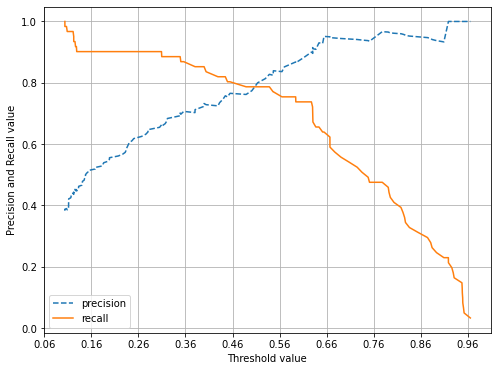

In [15]:
# 정밀도와 재현율의 임계값에 따른 값 변화를 곡선 형태의 그래프로 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray 와 이 threshold 에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')  # 정밀도 점선
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')  # 재현율 실선
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label 과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임계값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아진다.  
임계값을 계속 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대의 양상이 된다.  
위의 예제의 로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우 임계값이 약 0.45 지접에서 재현율과 정밀도가 비슷해지는 모습을 보였다.

## 정밀도와 재현율의 맹점

Positive 예측의 임계값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다.  
임계값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야 한다.  
그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용돼서는 안된다.  

### 정밀도가 100% 되는 방법

확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측한다.  
예를 들어 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 무조건 Positive, 다른 경우는 Negative 로 예측하는 것이다.  

정밀도 = TP / (TP + FP)  
전체 환자 1000명 중 확실한 Positive 징후만 가진 환자는 단 1명이라고 하면 이 한 명만 Positive로 예측하고 나머지는 모두 Negative 로 예측하더라고 FP는 0, TP는 1이 되므로 정밀도는 1/(1+0) 으로 100% 가 된다.

### 재현율이 100%가 되는 방법

모든 환자를 Positive 로 예측하면 된다. 재현율 = TP / (TP + FN) 이므로 환자 1000명을 다 Positive로 예측하는 것이다.  
이 중 실제 양성인 사람 30명 정도라도 TN이 수치에 포함되지 않고 FN은 아예 0이므로 30/(30+0) 으로 100% 가 된다.

이처럼 정밀도와 재현율 성능 수치도 어느 한쪽만 참고하면 극단적인 수치 조작이 가능하다.  
따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다.  
정밀도와 재현율 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다.

# F1 스코어

F1 스코어(Score)는 정밀도와 재현율을 결합한 지표로 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

<div>
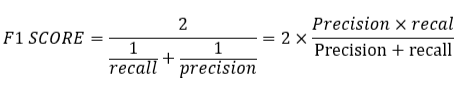
</div>

만일 A 예측 모델의 경우 정밀도가 0.9, 재현율이 0.1로 극단적인 차이가 나고, B 예측 모델은 정밀도가 0.5, 재현율이 0.5로 정밀도와 재현율이 큰 차이가 없다면 A 예측 모델의 F1 스코어는 0.18이고, B 예측 모델의 F1 스코어는 0.5로 B 모델이 A 모델에 비해 매우 우수한 F1 스코어를 가지게 된다.

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [17]:
# 위에서 정의한 get_clf_eval() 함수에 F1 스코어를 구하는 로직 추가

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 스코어 print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786
임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


# ROC 곡선과 AUC

ROC 곡선(Receiver Operation Characteristic Curve)은 우리말로 수신자 판단 곡선으로 불린다.  
일반적으로 의학 분야에서 많이 사용되지만, 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표이다.  
ROC 곡선은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선이다.  
FPR을 X 축으로, TPR 을 Y 축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.

민감도(TPR) : 실제값 Positive(양성)가 정확히 예측돼야 하는 수준을 나타낸다. (질병이 있는 사람은 질병이 있는 것으로 양성 판정. =재현율)  
특이성(TNR) : 실제값 Negative(음성)가 정확히 예측돼야 하는 수준을 나타낸다. (질병이 없는 건강한 사람은 질병이 없는 것으로 음성 판정. Specificity)

TPR = TP / (FN + TP)    
TNR = TN / (FP + TN)  

FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성

<div>
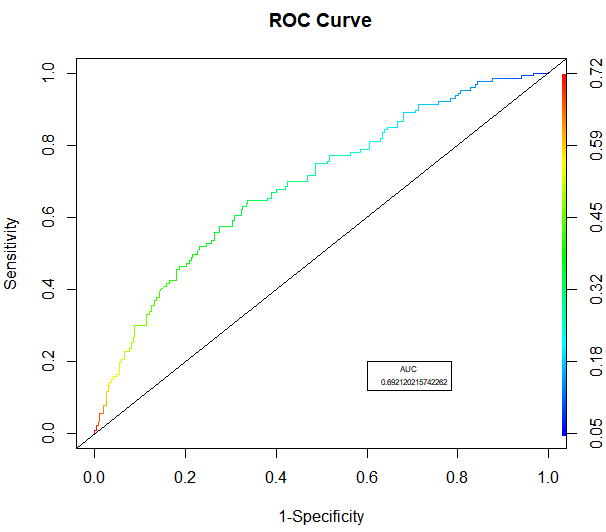
</div>

가운데 직선은 ROC 곡선의 최저 값이다. ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것이다.  
ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구한다. FPR을 변경하는 방법은 분류 결정 임계값을 변경하면 된다.  

분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이기 때문에 FPR을 0으로 만들려면 임계값을 1로 지정하면 된다.  
임계값을 1로 지정하면 Positive 예측 기준이 매우 높기 때문에 분류기(Classifier)가 임계값보다 높은 확률을 가진 데이터를 Positive로 예측할 수 없기 때문이다. 즉, 아예 Positive로 예측하지 않기 때문에 FP 값이 0이 되므로 자연스럽게 FPR은 0이 된다.  

FPR을 1로 만들려면 TN을 0으로 만들면 된다. TN을 0으로 만들려면 임계값을 0으로 지정하면 된다.  
그럼 분류기의 Positive 확률 기준이 너무 낮아서 다 Positive로 예측한다. 그럼 아예 Negative 예측이 없기 때문에 TN이 0이 되고 FPR 값은 1이 된다.

이렇게 임계값을 1부터 0까지 변화시키면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR 값을 구하는 것이 ROC 곡선이다.

In [18]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 Step 으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값: ', np.round(thresholds[thr_index], 2))

# 5 Step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임계값:  [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임계값별 TPR:  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


임계값이 1에 가까운 값에서 점점 작아질때 TPR은 점점 커진다. 그리고 FPR이 조금씩 커질 때 TPR은 가파르게 커짐을 알 수 있다.

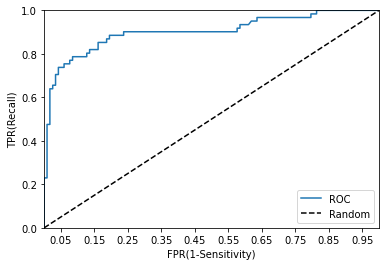

In [19]:
import matplotlib.pyplot as plt

def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프로 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정한다. ACU(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치이다.  
AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다.  
가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡산이 되어 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치를 얻게 된다. 가운데 대각선 직선은 랜덤 수준의(동전 던지기 수준) 이진 분류 AUC 값으로 0.5 이다. 따라서 보통의 분류는 0.5 이상의 AUC 값을 가진다.

In [20]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

# 피마 인디언 당뇨병 예측

피마 인디언 당뇨병 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터이다. 보통 당뇨 원이으로 식습관과 유전을 꼽는다.  
피마 지역은 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만, 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자가 생겨났다.  

데이터 세트는 https://www.kaggle.com/uciml/pima-indians-diabetes-database 에서 다운로드

Pregnancies	: 임신 횟수  
Glucose : 포도당 부하 검사 수치  
BloodPressure : 혈압(mm Hg)  
SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)  
Insulin : 혈청 인슐린(mu U/ml)  
BMI : 체질량지수(체중(kg)/(키(m))^2)  
DiabetesPedigreeFunction : 당뇨 내력 가중치 값  
Age : 나이  
Outcome : 클래스 결정 값(0 또는 1)

In [22]:
# 데이터 로드 및  Outcome 클래스 결정값의 분포와 데이터 개략적 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('C:\\Users\\jjku0\\OneDrive\\data\\diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


전체 768개의 데이터 중에서 Negative 값 0이 500개, Positive 값 1이 268개로 Negative가 상대적으로 많다.

In [23]:
# feature의 타입과 Null의 개수
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Null 값은 없으며 피처의 타입은 모두 숫자형이다. 임심 횟수, 나이와 같은 숫자형 피처와 당뇨 겸사 수치 피처로 구성된 특정으로 볼 때 별도의 피처 인코딩은 필요하지 않아 보인다.

In [24]:
# 로지스틱 회귀를 이용해 예측 모델 생성

# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)
# stratify = y : y 데이터의 비율을 유지하여 분할

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC: 0.7919


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


예측 정확도가 77.27%, 재현율은 57.41%로 측정됐다. 전체 데이터의 65%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰보겠다.  
먼저 정밀도 재현율 곡선을 보고 임계값별 정밀도와 재현율 값의 변화를 확인하겠다.

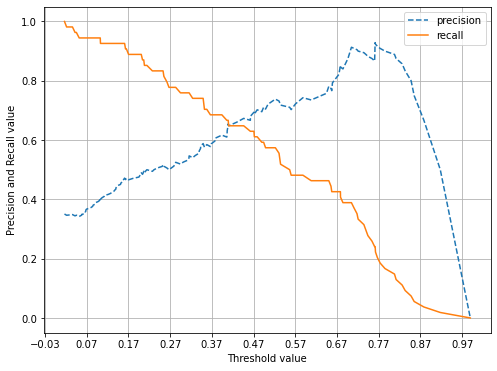

In [25]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

재현율 곡선을 보면 임계값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같지만 두 개의 지표 모두 0.7이 안되는 수치로 보인다. 여전히 두 지표의 값이 낮으므로 임계값을 인위적으로 조작하기 전에 다시 데이터 값을 점검하겠다.

In [26]:
# 피처 값의 분포도
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min() 값이 0으로 돼 있는 피처가 상당히 많다. 예를 들어 Glucose 피처는 포도당 수치인데 min 값이 0인 것은 말이 되지 않는다.  
Glucose 피처의 히스토그램을 확인해 보면 0 값이 일정 수준 존재하는 것을 알 수 있다.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

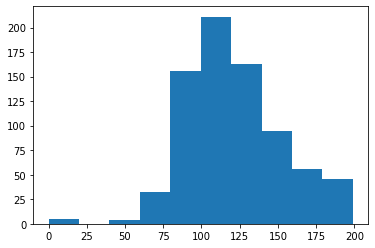

In [27]:
plt.hist(diabetes_data['Glucose'], bins=10)

min() 값이 0으로 돼 있는 피처에 대해 0 값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해 보겠다.  
확인할 피처는 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'이다. (Pregnancies는 출산 횟수를 의미하므로 제외한다.)

In [28]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 의 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 의 건수는 5, 퍼센트는 0.65%
BloodPressure 0 의 건수는 35, 퍼센트는 4.56%
SkinThickness 0 의 건수는 227, 퍼센트는 29.56%
Insulin 0 의 건수는 374, 퍼센트는 48.70%
BMI 0 의 건수는 11, 퍼센트는 1.43%


SkinThickness와 Insulin의 0 값은 각각 전체의 29.56%, 48.70%로 대단히 많다. 전체 데이터 선수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우에는 학습을 효과적으로 수행하기 어려울 것 같다. 위 피처의 0 값을 평균값으로 대체하겠다.

In [29]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0 값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [30]:
mean_zero_features

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

0 값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환하겠다.  
로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다.  
이후에 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표를 확인하겠다.

In [31]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됐다. 하지만 여전히 재현율 수치는 개선이 필요해 보인다.  
분류 결정 임계값을 변환시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해 보겠다.  
다음 코드는 임계값을 0.3에서 0.5까지 0.03씩 변화시키면서 재현율과 다른 평가 지표 값 변화를 출력한다.

In [32]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evalution 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [33]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963, F1: 0.6615, AUC: 0.8433
임계값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778, F1: 0.6774, AUC: 0.8433
임계값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1: 0.6667, AUC: 0.8433
임계값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1: 0.6667, AUC: 0.8433
임계값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1: 0.6792, AUC: 0.8433
임계값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1: 0.6857, AUC: 0.8433
임계값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
임계값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


위의 결과를 근거로 하면 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임계값은 0.3으로, 재현율 값이 0.7963 이다.  
하지만 정밀도가 0.5658로 매우 저조해졌으니 극단적인 선택으로 보인다. 임계값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값으로 보인다.  

앞에서 학습된 로지스틱 회귀 모델을 이용해 임계값을 0.48로 낮춘 상태에서 다시 예측을 해보겠다. 사이킷런의 predict() 메서드는 임계값을 마음대로 변환할 수 없으므로 별도의 로직으로 이를 구해야 한다. 앞에서 살펴본 Binarizer 클래스를 이용해 predict_proba()로 추출한 예측 결과 확률 값을 변환해 변경된 임계값에 따른 예측 클래스 값을 구해보겠다.

In [34]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼 값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, -1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
